In [144]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [148]:
params = {
    'legend.fontsize': 'x-large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

In [2]:
df = pd.read_csv('../csv/uk_house_prices/cluster_selection.csv')

In [3]:
df.head()

,seed,N,D,num_clusters,lengthscale_mult,lengthscale,kernel_var,noise_var,method,proj,ctr,feature_dist,rmse,test_kl,test_mnll,test_mean_mse,test_var_mse
0,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201896,rff,gaussian,0.0,None,0.643688,6986.926758,1.144562,0.201386,0.000205
1,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201896,rff,srht,0.0,None,0.658580,7778.296875,1.192859,0.223981,0.000207
2,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,rademacher,0.0,"[1, 1, 1, 2, 2]",0.500072,1490.957275,0.737001,0.042770,0.000053
3,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201896,maclaurin,srht,0.0,"[1, 1, 1, 2, 2]",0.501921,1470.311768,0.740949,0.042606,0.000043
4,0.0,10000.0,16.0,1722.0,0.125,0.248995,0.505562,0.201896,rff,gaussian,0.0,None,0.603194,5127.746582,1.019226,0.150994,0.000202


In [9]:
def get_error_over_input(config, error_field='test_kl', input_field='lengthscale_mult', D=8.0):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['ctr'] == config['ctr'])]
    df_sel = df_sel[(df_sel['D'] == D)]
    df_sel = df_sel.groupby([input_field])
    
    cluster_means = df_sel['num_clusters'].mean().values
    error_means = df_sel['test_kl'].mean()
    error_stds = df_sel['test_kl'].std()
    
    return df_sel.groups.keys(), error_means, error_stds, cluster_means

In [81]:
def plot_csv(
    ax, csv_file, configs,
    error_field='rel_frob_error',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel=''
):
    
    bar_positions = []
    data_names = []
        
    df = pd.read_csv(csv_file)
    Ds = np.sort(df['D'].unique())
    df = df[df['D'].isin(Ds)]

    bar_positions = np.arange(len(Ds))
    width = 1./(len(configs)+1)
    
    for j, (name, config) in enumerate(configs):
        df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
        df_sel = df_sel[(df_sel['ctr'] == config['ctr'])]
        df_sel = df_sel[(df_sel['lengthscale_mult'] == 2.0)]
        df_sel = df_sel.groupby(['D'])

        cluster_means = df_sel['num_clusters'].mean().values
        error_means = df_sel['test_kl'].mean()
        error_stds = df_sel['test_kl'].std()

        ax.bar(
            bar_positions + j*width, error_means,
            yerr=error_stds,
            error_kw=dict(lw=1, capsize=1, capthick=1, alpha=0.3),
            color=config['color'],
            width=width,
            label=name,
            align='edge'
        )

    if x_axis:
        ax.set_xticks(bar_positions+len(configs)*width/2.)
        ax.set_xticklabels(Ds)
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

    if error_field == 'test_kl':
        ax.yaxis.set_major_formatter(FormatStrFormatter("%.0e"))

    if logscale:
        ax.set_yscale('log')

    if ylabel != '':
        ax.set_ylabel(ylabel)

    ax.legend(loc='upper center', ncol=8)

In [154]:
def plot_abc(configs, ax):
    for config_name, config in configs:
        for D, linestyle in zip([8.0, 32.0, 256.0], ['solid', 'dashed', 'dotted']):
            keys, means, stds, cluster_means = get_error_over_input(config, D=D)

            if config_name == 'RFF':
                ax.hlines(
                    means.mean(),
                    xmin=list(keys)[0],
                    xmax=list(keys)[-1],
                    color='orange',
                    linewidth=3 if linestyle=='dotted' else 2,
                    linestyle=linestyle,
                    label=config_name + ' (D={})'.format(int(D)),
                    alpha=1.0 #D/128.0
                )
                continue

            ax.plot(
                list(keys),
                means.values,
                label=config_name + ' (D={})'.format(int(D)),
                marker='o',
                linewidth=3 if linestyle=='dotted' else 2,
                linestyle=linestyle,
                markersize=10,
                color=config['color']
            )
            ax.fill_between(
                list(keys),
                means.values-stds.values,
                means.values+stds.values,
                color=config['color'],
                alpha=0.2
            )

    ax.legend()
    ax.set_xscale('log')
    ax.set_xlim(2**4, 2**(-3))
    # plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    ax.set_xticks(list(keys)[::-1], [str(key) + '\n(' + str(int(mean)) + ')' for key, mean in zip(list(keys)[::-1], cluster_means[::-1])])
    ax.set_xlabel('Multiplier\n(Number Clusters)')
    ax.set_ylabel('Test KL Divergence')

In [102]:
colors = plt.get_cmap('tab20c')(np.linspace(0, 0.8, 16)) #[::2]

In [160]:
configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0, 'color': colors[4]}),
#     ('RFF', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0, 'color': colors[0]}),
#     ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0}),
    ('Macl. SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0, 'color': colors[2]}),
#     ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0})
]

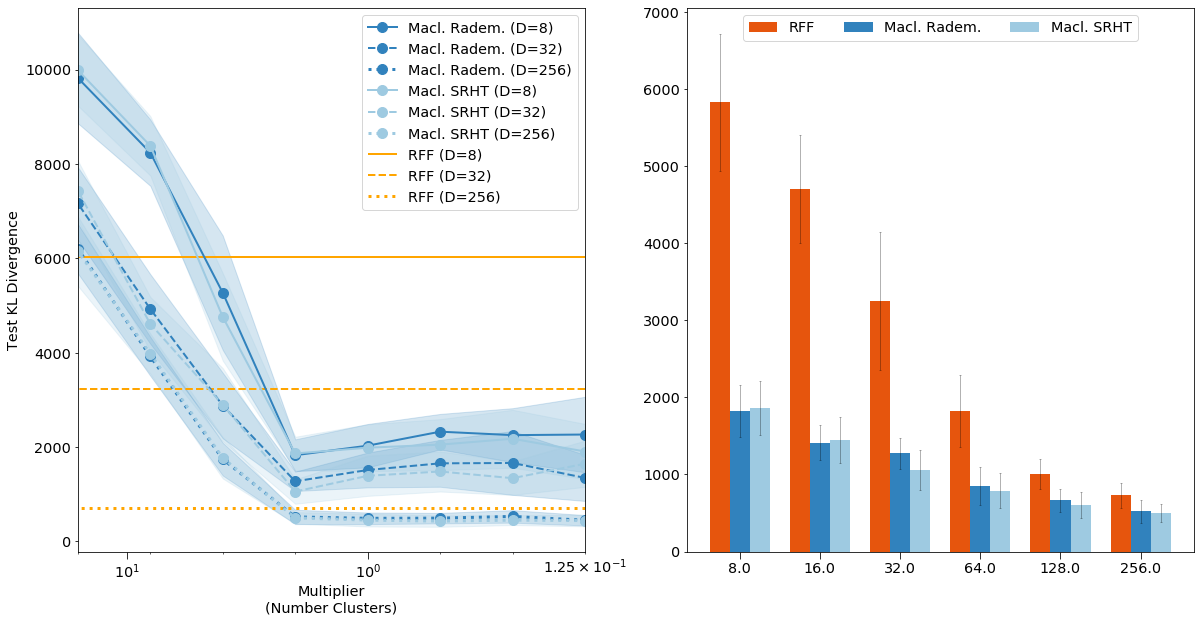

In [161]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

plot_abc(configs, axes[0])
plot_csv(axes[1], '../csv/uk_house_prices/cluster_selection.csv', configs,
    error_field='rel_frob_error',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel=''
)


plt.show()